In [147]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [148]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

In [149]:
import warnings
warnings.filterwarnings('ignore')

In [150]:
!pip install dagshub mlflow
import dagshub
import mlflow
dagshub.init(repo_owner='jgushiann', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

Initialized MLflow to track repo "jgushiann/IEEE-CIS-Fraud-Detection"

Repository jgushiann/IEEE-CIS-Fraud-Detection initialized!

In [151]:
mlflow.set_experiment("XGBoost_Training")
mlflow.end_run()

# Data Loading

In [152]:
with mlflow.start_run(run_name="XGBoost_Data_Loading"):
    train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
    test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
    
    train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
    test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
    
    print(f"Train shape: {train_transaction.shape}")
    print(f"Test shape: {test_transaction.shape}")

    mlflow.log_param("train_transaction_rows", train_transaction.shape[0])
    mlflow.log_param("train_transaction_cols", train_transaction.shape[1])

Train shape: (590540, 394)
Test shape: (506691, 393)
🏃 View run XGBoost_Data_Loading at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/fc70e95238934004a6b45f1979d56f2c
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


# Cleaning

In [153]:
with mlflow.start_run(run_name="XGBoost_Cleaning"):
    #protecting RAM
    def reduce_mem_usage(df, verbose=True):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2    
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
        end_mem = df.memory_usage().sum() / 1024**2
        if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        return df

    train = train_transaction.merge(train_identity, how='left', on='TransactionID')
    test = test_transaction.merge(test_identity, how='left', on='TransactionID')

    print(f"Train merged shape: {train.shape}")
    print(f"Test merged shape: {test.shape}")
    
    # dropping NaN columns
    missing_train = train.isnull().mean()
    missing_cols = missing_train[missing_train > 0.9].index.tolist() #wasashleli

    train = train.drop(columns=missing_cols)

    test_cols = [col for col in missing_cols if col in test.columns]
    test = test.drop(columns=test_cols)

    print(f"Train shape after dropping: {train.shape}")
    print(f"Test shape after dropping: {test.shape}")

    # filling missing vals
    for col in train.columns:
        if col == 'isFraud':
            continue
        if train[col].dtype == 'object':
            train[col] = train[col].fillna('unknown')   #categoricals
            if col in test.columns:
                test[col] = test[col].fillna('unknown')
        else:
            train[col] = train[col].fillna(-999)        #numericals
            if col in test.columns:
                test[col] = test[col].fillna(-999)
                
    y_train = train['isFraud']
    X_train = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
    X_test = test.drop(['TransactionID', 'TransactionDT'], axis=1)

    cat_cols = X_train.select_dtypes(include='object').columns

    for col in cat_cols:
        le = LabelEncoder()
        
        if col in X_test.columns:
            full_data = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
            le.fit(full_data)
            X_train[col] = le.transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))
        else:
            X_train[col] = le.fit_transform(X_train[col].astype(str))

    X_train = reduce_mem_usage(X_train)
    X_test = reduce_mem_usage(X_test)

    #logging
    mlflow.log_param("initial_train_cols", train_transaction.shape[1] + train_identity.shape[1] - 1)
    mlflow.log_param("final_train_cols", train.shape[1])
    mlflow.log_param("dropped_cols_count", len(missing_cols))

Train merged shape: (590540, 434)
Test merged shape: (506691, 433)
Train shape after dropping: (590540, 422)
Test shape after dropping: (506691, 431)
Mem. usage decreased to 507.99 Mb (73.1% reduction)
Mem. usage decreased to 502.06 Mb (69.7% reduction)
🏃 View run XGBoost_Cleaning at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/f877c35cc59f42ec88bf20ab7eaf2b6d
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


# Feature Engineering

In [154]:
with mlflow.start_run(run_name="XGBoost_Feature_Engineering"):
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    
    if 'TransactionDT' in train.columns:
        X_train_fe['TransactionHour'] = (train['TransactionDT'] / 3600) % 24
        X_train_fe['TransactionDay'] = (train['TransactionDT'] / (3600 * 24)) % 7
        X_train_fe['TransactionMonth'] = (train['TransactionDT'] / (3600 * 24 * 30)) % 12
        
        X_test_fe['TransactionHour'] = (test['TransactionDT'] / 3600) % 24
        X_test_fe['TransactionDay'] = (test['TransactionDT'] / (3600 * 24)) % 7
        X_test_fe['TransactionMonth'] = (test['TransactionDT'] / (3600 * 24 * 30)) % 12
  
    if 'TransactionAmt' in X_train_fe.columns:
        X_train_fe['TransactionAmt_Log'] = np.log1p(X_train_fe['TransactionAmt'])
        X_test_fe['TransactionAmt_Log'] = np.log1p(X_test_fe['TransactionAmt'])
        X_train_fe['TransactionAmt_Percentile'] = X_train_fe['TransactionAmt'].rank(pct=True)
        X_test_fe['TransactionAmt_Percentile'] = X_test_fe['TransactionAmt'].rank(pct=True)

    
    for col in ['card1', 'card2', 'card3', 'card5']:
        if col in X_train_fe.columns:
            
            X_train_fe[col] = X_train_fe[col].astype('float32')
            X_test_fe[col] = X_test_fe[col].astype('float32')

            count_map = X_train_fe[col].value_counts().to_dict()
            X_train_fe[f'{col}_count'] = X_train_fe[col].map(count_map)
            X_test_fe[f'{col}_count'] = X_test_fe[col].map(count_map)

    
    if 'card1' in X_train_fe.columns and 'addr1' in X_train_fe.columns:
        X_train_fe['card1_addr1'] = X_train_fe['card1'].astype(str) + '_' + X_train_fe['addr1'].astype(str)
        X_test_fe['card1_addr1'] = X_test_fe['card1'].astype(str) + '_' + X_test_fe['addr1'].astype(str)
        
        le = LabelEncoder()
        combined = pd.concat([X_train_fe['card1_addr1'], X_test_fe['card1_addr1']], axis=0)
        le.fit(combined.astype(str))
        X_train_fe['card1_addr1'] = le.transform(X_train_fe['card1_addr1'].astype(str))
        X_test_fe['card1_addr1'] = le.transform(X_test_fe['card1_addr1'].astype(str))
  
    if 'P_emaildomain' in X_train_fe.columns and 'R_emaildomain' in X_train_fe.columns:
        X_train_fe['email_match'] = (X_train_fe['P_emaildomain'] == X_train_fe['R_emaildomain']).astype(int)
        X_test_fe['email_match'] = (X_test_fe['P_emaildomain'] == X_test_fe['R_emaildomain']).astype(int)
    
    device_cols = [col for col in X_train_fe.columns if col.startswith('DeviceType')]
    if device_cols:
        X_train_fe['DeviceType_count'] = X_train_fe[device_cols].sum(axis=1)
        X_test_fe['DeviceType_count'] = X_test_fe[device_cols].sum(axis=1)

    id_cols = [col for col in X_train_fe.columns if col.startswith('id_') and col in X_test_fe.columns]
    if id_cols:
        X_train_fe['id_count'] = X_train_fe[id_cols].sum(axis=1)
        X_test_fe['id_count'] = X_test_fe[id_cols].sum(axis=1)

  
    if 'TransactionAmt' in X_train_fe.columns and 'card1' in X_train_fe.columns:
        card1_amt_mean = X_train_fe.groupby('card1')['TransactionAmt'].transform('mean')
        card1_amt_std = X_train_fe.groupby('card1')['TransactionAmt'].transform('std').fillna(0)

        X_train_fe['TransactionAmt_to_mean_card1'] = X_train_fe['TransactionAmt'] / card1_amt_mean
        X_train_fe['TransactionAmt_to_std_card1'] = X_train_fe['TransactionAmt'] / card1_amt_std.replace(0, 1)

        card1_mean_dict = X_train_fe.groupby('card1')['TransactionAmt'].mean().to_dict()
        card1_std_dict = X_train_fe.groupby('card1')['TransactionAmt'].std().fillna(0).to_dict()

        X_test_fe['TransactionAmt_to_mean_card1'] = X_test_fe['TransactionAmt'] / X_test_fe['card1'].map(card1_mean_dict).fillna(X_train_fe['TransactionAmt'].mean())
        X_test_fe['TransactionAmt_to_std_card1'] = X_test_fe['TransactionAmt'] / X_test_fe['card1'].map(card1_std_dict).fillna(1).replace(0, 1)
  
    X_train_fe = X_train_fe.fillna(-999)
    X_test_fe = X_test_fe.fillna(-999)

    print(f"Shape after feature engineering - X_train: {X_train_fe.shape}, X_test: {X_test_fe.shape}")


Shape after feature engineering - X_train: (590540, 433), X_test: (506691, 443)
🏃 View run XGBoost_Feature_Engineering at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/a6a0658b553d4686b8a09d9905215375
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [155]:
mlflow.log_param("features_before_engineering", X_train.shape[1])
mlflow.log_param("features_after_engineering", X_train_fe.shape[1])
mlflow.log_param("new_features_created", X_train_fe.shape[1] - X_train.shape[1])

14

In [156]:
X_train_fe = reduce_mem_usage(X_train_fe) 
X_test_fe = reduce_mem_usage(X_test_fe)

Mem. usage decreased to 527.14 Mb (7.5% reduction)
Mem. usage decreased to 517.53 Mb (7.1% reduction)


# Feature Selection

In [157]:
mlflow.end_run()

🏃 View run skittish-elk-624 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/fedaf9dc1af04043854c47a98873ade4
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [158]:
with mlflow.start_run(run_name="XGBoost_Feature_Selection"):
    print("Training a base XGBoost model for feature importance...")
    feature_selector = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        tree_method='hist'
    )
    sample_size = 100000
    if X_train_fe.shape[0] > sample_size:
        sample_idx = np.random.choice(X_train_fe.shape[0], sample_size, replace=False)
        X_sample = X_train_fe.iloc[sample_idx]
        y_sample = y_train.iloc[sample_idx]
    else:
        X_sample = X_train_fe
        y_sample = y_train
    
    feature_selector.fit(X_sample, y_sample)
    
    feature_importance = pd.DataFrame({
        'feature': X_train_fe.columns,
        'importance': feature_selector.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 20 features by importance:")
    print(feature_importance.head(20))

Training a base XGBoost model for feature importance...
Top 20 features by importance:
    feature  importance
306    V257    0.124368
307    V258    0.076081
250    V201    0.058605
238    V189    0.022566
20       C8    0.020428
119     V70    0.020141
343    V294    0.018494
83      V34    0.018185
16       C4    0.018006
317    V268    0.014789
357    V308    0.014259
236    V187    0.013965
17       C5    0.012996
118     V69    0.012153
13       C1    0.011147
26      C14    0.010590
367    V318    0.010542
376    V327    0.010360
382    V333    0.010299
274    V225    0.010234
🏃 View run XGBoost_Feature_Selection at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/2417a7ace5a641a98554325ff35536a5
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


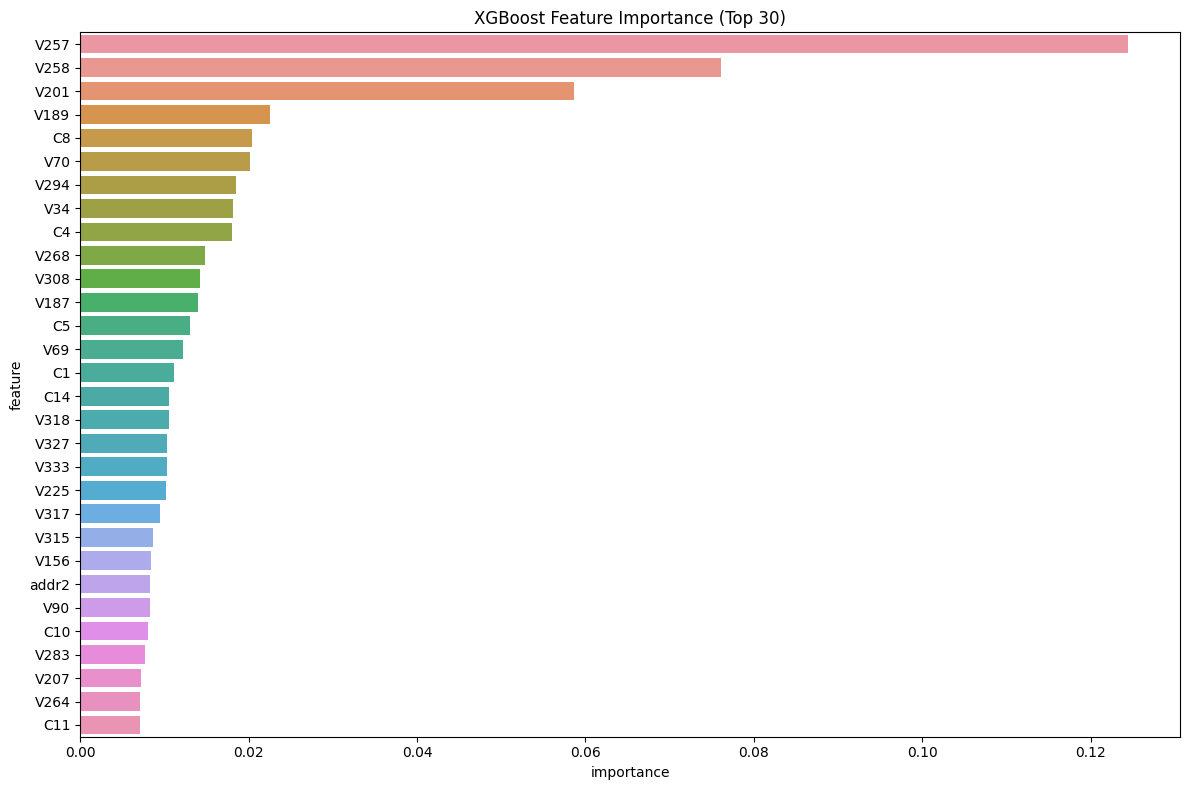

In [159]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(30))
plt.title('XGBoost Feature Importance (Top 30)')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')

In [160]:
n_top_features = 100  
top_features = feature_importance.head(n_top_features)['feature'].tolist()

available_top_features = [f for f in top_features if f in X_test_fe.columns]

X_train_selected = X_train_fe[available_top_features]
X_test_selected = X_test_fe[available_top_features]

print(f"Selected {len(available_top_features)} features out of {X_train_fe.shape[1]}")

print(f"Selected {len(top_features)} features out of {X_train_fe.shape[1]}")

Selected 97 features out of 433
Selected 100 features out of 433


In [161]:
mlflow.log_param("total_features_before_selection", X_train_fe.shape[1])
mlflow.log_param("total_features_after_selection", len(top_features))
mlflow.log_param("top_10_features", ', '.join(top_features[:10]))
mlflow.log_artifact('xgboost_feature_importance.png')

In [162]:
with open('top_features.txt', 'w') as f:
    for feature in top_features:
        f.write(f"{feature}\n")

    mlflow.log_artifact('top_features.txt')

# Training

In [163]:
mlflow.end_run()

🏃 View run popular-calf-442 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/c3867f0e1aee4acca6823c374db93d8a
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [164]:
with mlflow.start_run(run_name="XGBoost_Base_Model"):
    X_train_model, X_val, y_train_model, y_val = train_test_split(
        X_train_selected, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Training data shape: {X_train_model.shape}")
    print(f"Validation data shape: {X_val.shape}")
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        scale_pos_weight=1,  
        random_state=42,
        tree_method='hist' 
    )
    
    eval_set = [(X_val, y_val)]
    
    xgb_model.fit(
        X_train_model, 
        y_train_model,
        eval_set=eval_set,
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=True
    )
 
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"Base XGBoost ROC AUC: {roc_auc:.4f}")
    print(f"Base XGBoost PR AUC: {pr_auc:.4f}")
    

Training data shape: (472432, 97)
Validation data shape: (118108, 97)
[0]	validation_0-auc:0.76706
[1]	validation_0-auc:0.78242
[2]	validation_0-auc:0.79483
[3]	validation_0-auc:0.80571
[4]	validation_0-auc:0.81550
[5]	validation_0-auc:0.81743
[6]	validation_0-auc:0.81870
[7]	validation_0-auc:0.82604
[8]	validation_0-auc:0.84615
[9]	validation_0-auc:0.84718
[10]	validation_0-auc:0.84827
[11]	validation_0-auc:0.85048
[12]	validation_0-auc:0.85308
[13]	validation_0-auc:0.85571
[14]	validation_0-auc:0.86018
[15]	validation_0-auc:0.86096
[16]	validation_0-auc:0.86468
[17]	validation_0-auc:0.86810
[18]	validation_0-auc:0.86934
[19]	validation_0-auc:0.87061
[20]	validation_0-auc:0.87223
[21]	validation_0-auc:0.87451
[22]	validation_0-auc:0.87628
[23]	validation_0-auc:0.87725
[24]	validation_0-auc:0.87845
[25]	validation_0-auc:0.87889
[26]	validation_0-auc:0.88128
[27]	validation_0-auc:0.88214
[28]	validation_0-auc:0.88326
[29]	validation_0-auc:0.88404
[30]	validation_0-auc:0.88484
[31]	valid

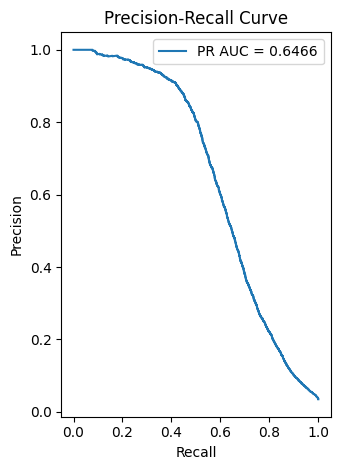

In [165]:
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('xgboost_base_model_curves.png')
    

In [166]:
    
    mlflow.log_param("n_estimators", xgb_model.n_estimators)
    mlflow.log_param("max_depth", xgb_model.max_depth)
    mlflow.log_param("learning_rate", xgb_model.learning_rate)
    mlflow.log_param("subsample", xgb_model.subsample)
    mlflow.log_param("colsample_bytree", xgb_model.colsample_bytree)
    
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_artifact('xgboost_base_model_curves.png')
    
   

In [167]:
    mlflow.xgboost.log_model(xgb_model, "xgboost_base_model")

2025/04/29 20:07:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [168]:
mlflow.end_run()

🏃 View run popular-trout-802 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/b69def70330244cc9b36f0eb3e8cb994
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [169]:
with mlflow.start_run(run_name="XGBoost_Hyperparameter_Tuning"):
    from sklearn.model_selection import GridSearchCV
    
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200],
        'colsample_bytree': [0.7, 0.8],
        'subsample': [0.7, 0.8]
    }
    
    xgb_tuning = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        tree_method='hist'  
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=xgb_tuning,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=skf,
        verbose=2,
        n_jobs=-1
    )
    
    sample_size_tuning = 100000
    if X_train_selected.shape[0] > sample_size_tuning:
        sample_idx = np.random.choice(X_train_selected.shape[0], sample_size_tuning, replace=False)
        X_tuning = X_train_selected.iloc[sample_idx]
        y_tuning = y_train.iloc[sample_idx]
    else:
        X_tuning = X_train_selected
        y_tuning = y_train
    
    print("Starting hyperparameter tuning...")
    grid_search.fit(X_tuning, y_tuning)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best CV score:", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    
    y_pred_proba_tuned = best_model.predict_proba(X_val)[:, 1]
    roc_auc_tuned = roc_auc_score(y_val, y_pred_proba_tuned)
    
    precision_tuned, recall_tuned, _ = precision_recall_curve(y_val, y_pred_proba_tuned)
    pr_auc_tuned = auc(recall_tuned, precision_tuned)
    
    print(f"Tuned XGBoost ROC AUC: {roc_auc_tuned:.4f}")
    print(f"Tuned XGBoost PR AUC: {pr_auc_tuned:.4f}")
   

Starting hyperparameter tuning...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   6.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   4.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=

In [170]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score

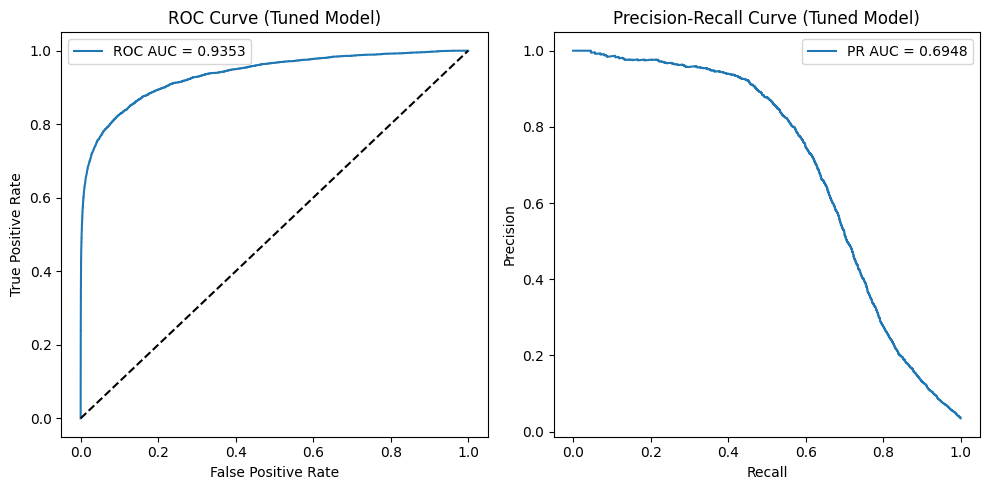

In [171]:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    fpr_tuned, tpr_tuned, _ = roc_curve(y_val, y_pred_proba_tuned)
    plt.plot(fpr_tuned, tpr_tuned, label=f'ROC AUC = {roc_auc_tuned:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Tuned Model)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall_tuned, precision_tuned, label=f'PR AUC = {pr_auc_tuned:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Tuned Model)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('xgboost_tuned_model_curves.png')
    
  

In [172]:
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("best_cv_score", grid_search.best_score_)
    mlflow.log_metric("val_roc_auc", roc_auc_tuned)
    mlflow.log_metric("val_pr_auc", pr_auc_tuned)
    mlflow.log_artifact('xgboost_tuned_model_curves.png')
    
    

In [173]:
mlflow.xgboost.log_model(best_model, "xgboost_tuned_model")

2025/04/29 20:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [174]:
mlflow.end_run()

🏃 View run worried-skunk-271 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/6fd1c9ddbb7b451a9277b158ec20b84b
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [175]:
with mlflow.start_run(run_name="XGBoost_Final_Pipeline"):
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    
    original_cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    original_num_cols = X_train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 
                                                     'float16', 'float32', 'float64']).columns.tolist()
 
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-999))
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('encoder', LabelEncoder())  # Will be applied to each column separately
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, original_num_cols),
            ('cat', categorical_transformer, original_cat_cols)
        ])
    

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', best_model)
    ])
    
    run_id = mlflow.active_run().info.run_id
    model_uri = f"runs:/{run_id}/xgboost_tuned_model"
    model_details = mlflow.register_model(model_uri=model_uri, name="XGBoost_Fraud_Detection")

Successfully registered model 'XGBoost_Fraud_Detection'.
2025/04/29 20:12:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost_Fraud_Detection, version 1
Created version '1' of model 'XGBoost_Fraud_Detection'.


🏃 View run XGBoost_Final_Pipeline at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/8dca04c24c49452daafbc40157ba5d69
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [176]:
    mlflow.log_param("model_registry_name", "XGBoost_Fraud_Detection")
    mlflow.log_param("model_version", model_details.version)

'1'

In [177]:
    mlflow.log_param("feature_selection_count", len(top_features))
    mlflow.log_text(', '.join(top_features), "selected_features.txt")
    
    print("Final model registered in MLflow Model Registry as 'XGBoost_Fraud_Detection'")
    print(f"Model version: {model_details.version}")

Final model registered in MLflow Model Registry as 'XGBoost_Fraud_Detection'
Model version: 1
